In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.measure import find_contours
from skimage.draw import rectangle
from skimage.filters import threshold_otsu
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
def draw_lines(img, lines):
    img = np.copy(img)
    blank_image = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)

    for line in lines:
        for x1, y1, x2, y2 in line:
            if(abs(y1-y2)>40): # np.sqrt(np.sum([np.square(y2-y1),np.square(x2-x1)])) #Euclidean distance
                cv2.line(blank_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    img = cv2.addWeighted(img, 0.8, blank_image, 1, 0.0)
    return img


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def threshold(img):
    image=rgb2gray(img)
    global_thresh = threshold_otsu(image)
    binary_global = image
    binary_global[binary_global < global_thresh] = 0
    return binary_global

def sobel_H_V_angles(img):
    # gray_img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2GRAY)
    blur_img = gaussian_blur(img, 9)
    sobelx = cv2.Sobel(src=blur_img, ddepth=cv2.CV_64F, dx=1, dy=0) # Sobel on the X axis
    sobelx = abs(sobelx) + 1
    sobely = cv2.Sobel(src=blur_img, ddepth=cv2.CV_64F, dx=0, dy=1) # Sobel on the Y axis
    sobely = abs(sobely) + 1
    angles = abs(sobely/sobelx) #np.arctan
    return sobelx, sobely, angles


climbing-lane.jpg


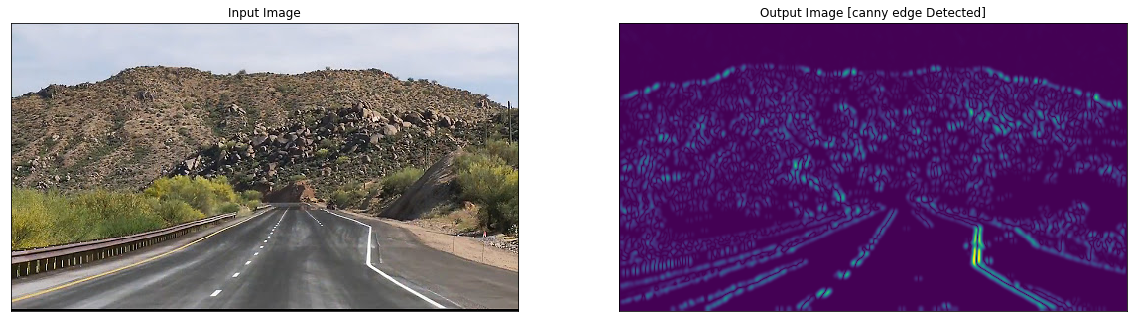

road4.jfif


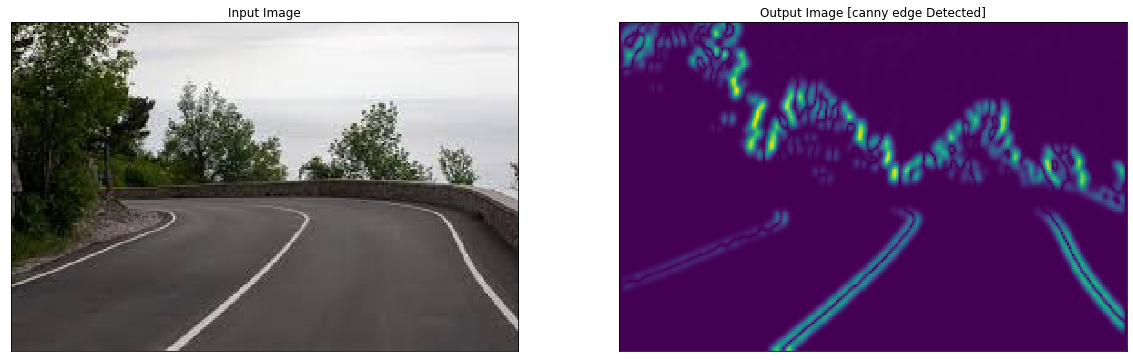

test10.jpg


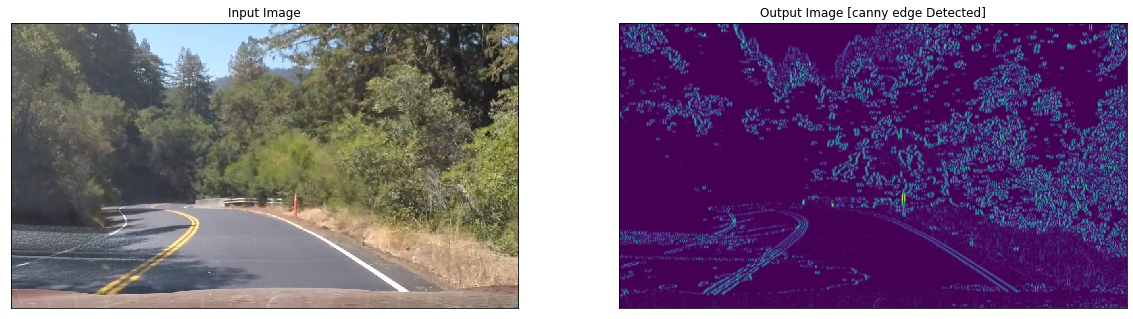

In [3]:

for image_path in list(os.listdir('./test_images')):
    print(image_path)
    fig = plt.figure(figsize=(20, 10))
    image = mpimg.imread(f'./test_images/{image_path}')
    ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("Input Image")
    ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
    thresholded = threshold(image)

    # edge = cv2.Canny(np.uint8(thresholded), 50, 200, apertureSize=3)
    sobelx, sobely, angles = sobel_H_V_angles(thresholded)
    plt.imshow(sobelx)
    ax.set_title("Output Image [canny edge Detected]")
    plt.show()

In [4]:
def textur_filtring_with_angles(image, edged_img, window_height, window_width, textur_threshold):
    result = np.copy(edged_img)
    half_height = window_height//2 # Y
    half_width = window_width//2 # X
    sobelx, sobely, angles = sobel_H_V_angles(image)
    for i in range(half_height, result.shape[0] - half_height - 10):
        for j in range(half_width, result.shape[1] - half_width):
            # mean = np.average(angles[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)])
            # var = np.average((angles[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)] - mean)**2)
            # this approach uses to minimuize time and calculations 
            min_angle = np.min(angles[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)])
            max_angle = np.max(angles[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)])
            if(max_angle - min_angle > textur_threshold):
                result[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)] = 0
    return result

def textur_filtring_with_magnitude(image, edged_img, window_height, window_width, textur_threshold):
    result = np.copy(edged_img)
    half_height = window_height//2 # Y
    half_width = window_width//2 # X
    for i in range(half_height, result.shape[0] - half_height - 10):
        for j in range(half_width, result.shape[1] - half_width):
            if(np.sum(edged_img[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)] > 0) > textur_threshold):
                result[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)] = 0
    return result


C:\Users\Nada\Anaconda3\lib\site-packages\skimage\filters\thresholding.py:274: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (291, 512, 3) looks like an RGB image
  warn(msg.format(image.shape))


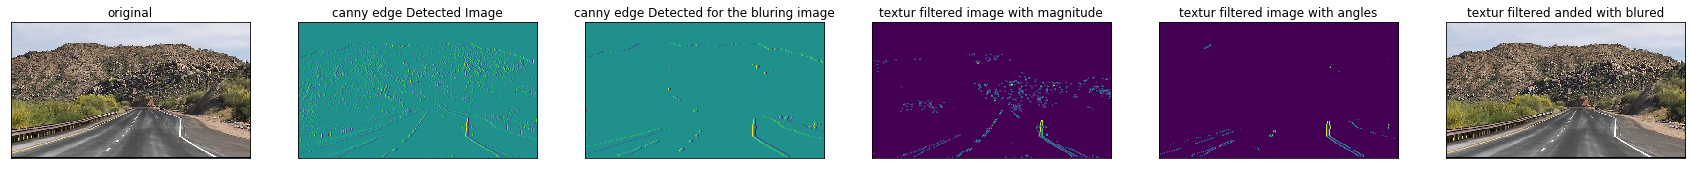

Lossy conversion from float64 to uint8. Range [0.0, 2.939985882352941]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\Nada\Anaconda3\lib\site-packages\skimage\filters\thresholding.py:274: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (181, 279, 3) looks like an RGB image
  warn(msg.format(image.shape))


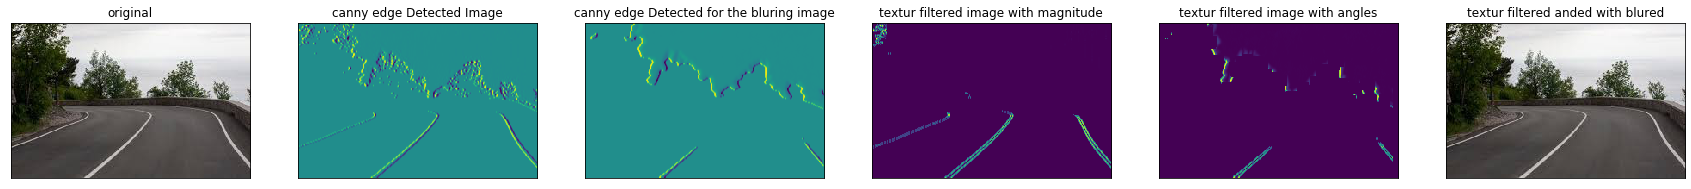

C:\Users\Nada\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: road4.jfif is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from float64 to uint8. Range [0.0, 2.632881568627451]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\Nada\Anaconda3\lib\site-packages\skimage\filters\thresholding.py:274: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (720, 1280, 3) looks like an RGB image
  warn(msg.format(image.shape))


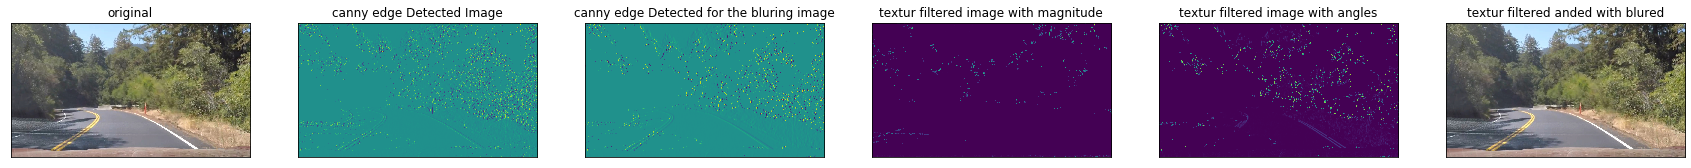

Lossy conversion from float64 to uint8. Range [0.0, 2.459398823529412]. Convert image to uint8 prior to saving to suppress this warning.


In [5]:
from skimage.filters import gaussian
from skimage.io import imsave, imread
count = 0
for image_path in list(os.listdir('./test_images')):
    count = count + 1
    fig = plt.figure(figsize=(30, 10))
    image = mpimg.imread(f'./test_images/{image_path}')
    bin_img = threshold(image)
    ax = fig.add_subplot(1, 5, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("original")
    edge = cv2.Sobel(src=bin_img, ddepth=cv2.CV_64F, dx=1, dy=0) # Sobel on the X axis
    ax = fig.add_subplot(1, 5, 2,xticks=[], yticks=[])
    plt.imshow(edge)
    ax.set_title("canny edge Detected Image")
    ########################################################################
    blur_img = gaussian_blur(image, 9)
    blur_bin = threshold(blur_img)
    blur_edged = cv2.Sobel(src=blur_bin, ddepth=cv2.CV_64F, dx=1, dy=0) # Sobel on the X axis 
    ax = fig.add_subplot(1, 5, 3,xticks=[], yticks=[])
    plt.imshow(blur_edged)
    ax.set_title("canny edge Detected for the bluring image")
    ########################################################################
    ax = fig.add_subplot(1, 5, 4,xticks=[], yticks=[])
    filtered_image_with_magnitude = abs(textur_filtring_with_magnitude(image, edge, 20, 40, 150)) #try 200 or 150
    plt.imshow(filtered_image_with_magnitude)
    ax.set_title("textur filtered image with magnitude")
    ########################################################################
    ax = fig.add_subplot(1, 5, 5,xticks=[], yticks=[])
    filtered_image_with_angles = abs(textur_filtring_with_angles(image, blur_edged, 7, 7, 40)) 
    plt.imshow(filtered_image_with_angles)
    ax.set_title("textur filtered image with angles")

   
    filtered_image_with_angles[0:filtered_image_with_angles.shape[0]//2, : ] = 0 
    imsave(image_path,filtered_image_with_angles)

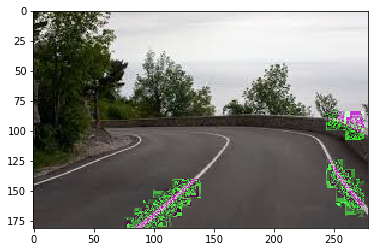

In [6]:
import skimage.io as io
import matplotlib.pyplot as plt

image1 = io.imread("road4.jfif")
image = io.imread("test_images/road4.jfif")
kernel = np.ones((5,5), dtype=np.uint8)
image1 = cv2.dilate(image1, kernel, iterations = 2)
image[:, :, 1] = image[:, :, 1] + image1*(255 - image[:, :, 1])
plt.imshow(image)
plt.show()

In [9]:
def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    #lines_edges = cv2.polylines(lines_edges,get_vertices(img), True, (0,0,255), 10)
    return lines_edges

In [10]:
def slope_lines(image,lines):
    
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] # Like /
    right_lines = [] # Like \
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #Vertical Lines
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1

                if m < 0:
                    left_lines.append((m,c))
                elif m >= 0:
                    right_lines.append((m,c))

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)


    for slope, intercept in [left_line, right_line]:

        #getting complete height of image in y1
        rows, cols = image.shape[:2]
        y1= int(rows) #image.shape[0]

        #taking y2 upto 60% of actual height or 60% of y1
        y2= int(rows*0.6) #int(0.6*y1)

        #we know that equation of line is y=mx +c so we can write it x=(y-c)/m
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        draw_lines(img, np.array([[[x1,y1,x2,y2]]]))
    
    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,255,0))
    return cv2.addWeighted(image,0.7,img,0.4,0.)

In [11]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img = slope_lines(line_img,lines)
    return line_img


In [12]:
def draw_lines(img, lines):
    img = np.copy(img)
    blank_image = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)

    for line in lines:
        for x1, y1, x2, y2 in line:
            if(abs(y2-y1) > 20):
               cv2.line(blank_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    img = cv2.addWeighted(img, 0.8, blank_image, 1, 0.0)
    return img


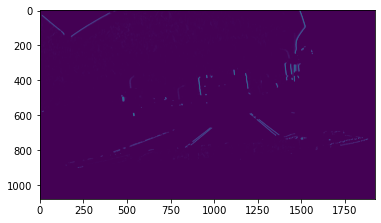

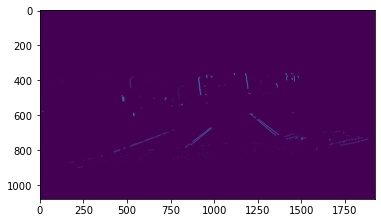

In [19]:
import skimage.io as io
import matplotlib.pyplot as plt

image1 = io.imread("00000.jpg")
image = np.copy(image1)
plt.imshow(image1)
plt.show()

image_cropped_lower = image[int(image.shape[0]/3):]

image[:int(image.shape[0]/3)] = 0
image_cropped_upper = image[:int(image.shape[0]/3)]

thresholded = np.block([[image_cropped_upper],[image_cropped_lower]])

plt.imshow(thresholded)
plt.show()

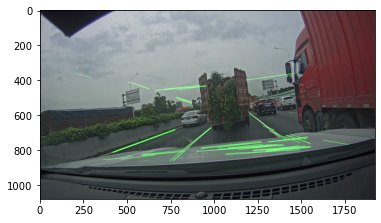

In [20]:

    image = mpimg.imread("test_images/00000.jpg")

    output = np.copy(image)
    houghed_lines = cv2.HoughLinesP(thresholded, rho=1, theta=np.pi/180,
                           threshold=200, lines=np.array([]), minLineLength=10, maxLineGap=30)
    output = draw_lines(image, houghed_lines)
   
       
    plt.imshow(output)